In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-11 04:35:59.331728: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 04:36:00.095011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
txt_file = 'data/kor_indie_text.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

433634


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [4]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue

    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

print(len(corpus))
print(corpus[:10])

210113
['<start> 돌아서는 너를 보며 <end>', '<start> 난 아무 말도 할 수 없었고 <end>', '<start> 슬퍼하기엔 짧았던 <end>', '<start> 나의 해는 저물어 갔네 <end>', '<start> 지나치는 모진 기억이 <end>', '<start> 바람 따라 흩어질 때면 <end>', '<start> 아무 일도 없듯이 보내주려 해 <end>', '<start> 아픈 맘이 남지 않도록 <end>', '<start> 안녕 멀어지는 나의 하루야 <end>', '<start> 빛나지 못한 나의 별들아 <end>']


In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 25000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)

    return tensor, tokenizer

In [6]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7f0d103ac110> 
 [[    2  4348    22 ...     0     0     0]
 [    2     7   161 ...     0     0     0]
 [    2     1  5437 ...     0     0     0]
 ...
 [    2   469    73 ...     0     0     0]
 [    2 10163 15694 ...     0     0     0]
 [    2    78     8 ...     0     0     0]]


In [7]:
tensor.shape

(210113, 24)

In [8]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : you
6 : 내
7 : 난
8 : 널
9 : 내가
10 : 날
11 : 수
12 : 그
13 : the
14 : me
15 : 더
16 : 이
17 : 너의
18 : 다
19 : 나는
20 : my


In [9]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (210113, 24)
소스문장 길이:  23
타겟문장 길이:  23


In [10]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (168090, 23)
Target Train 길이:  (168090, 23)
Source Test 길이:  (42023, 23)
Target Test 길이:  (42023, 23)


In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-11 04:36:17.634679: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


<_BatchDataset element_spec=(TensorSpec(shape=(256, 23), dtype=tf.int32, name=None), TensorSpec(shape=(256, 23), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 23), dtype=tf.int32, name=None), TensorSpec(shape=(256, 23), dtype=tf.int32, name=None))>


2024-04-11 04:36:17.688137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 04:36:17.688502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 04:36:17.689557: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

In [13]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [14]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 23, 25001), dtype=float32, numpy=
array([[[-6.79568446e-04,  4.94654803e-03,  2.95585743e-03, ...,
          9.66575835e-03, -7.33998278e-03, -5.66784292e-03],
        [-3.74516193e-03, -8.37373920e-03,  1.53106765e-03, ...,
          5.49963769e-03, -2.02333760e-02,  7.44386856e-03],
        [ 3.02126142e-03,  5.83120901e-03,  9.76925250e-03, ...,
          1.36952894e-02, -1.44474208e-02,  8.62640887e-03],
        ...,
        [-2.88213119e-02,  5.80374757e-03,  3.78409103e-02, ...,
         -7.99067020e-02,  9.95745957e-02,  7.73259392e-03],
        [ 8.62923339e-02, -2.92145163e-02,  3.56855467e-02, ...,
          5.10927290e-02,  8.80074799e-02,  3.52847613e-02],
        [-4.02485766e-02, -2.46322155e-02, -1.96233802e-02, ...,
         -5.02283610e-02,  9.03320685e-02,  2.63535902e-02]],

       [[-6.79568446e-04,  4.94654803e-03,  2.95585743e-03, ...,
          9.66575835e-03, -7.33998278e-03, -5.66784292e-03],
        [ 4.02816711e-03, -5.49328281e-03,  4

In [15]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,400,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    25,626,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,436,201 (135.18 MB)

 Trainable params: 35,436,201 (135.18 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [18]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1712810196.099856  440238 service.cc:145] XLA service 0x7f0c2c005c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712810196.099911  440238 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-11 04:36:36.153461: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-11 04:36:36.656537: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712810197.550284  440301 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 1748 bytes spill stores, 2168 bytes spill loads

I0000 00:00:1712810197.588146  440299 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1712810

656/656 ━━━━━━━━━━━━━━━━━━━━ 178s 257ms/step - loss: 1.9270
Epoch 2/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 169s 258ms/step - loss: 1.3584
Epoch 3/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 170s 258ms/step - loss: 1.2375
Epoch 4/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 170s 258ms/step - loss: 1.1349
Epoch 5/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 170s 258ms/step - loss: 1.0271
Epoch 6/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 170s 258ms/step - loss: 0.9351
Epoch 7/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 170s 258ms/step - loss: 0.8650
Epoch 8/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 170s 258ms/step - loss: 0.8111
Epoch 9/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 170s 258ms/step - loss: 0.7699
Epoch 10/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 169s 258ms/step - loss: 0.7416


In [20]:
model.save('rnn_kor_indie.keras')
model.save('rnn_kor_indie.h5')
tf.saved_model.save(model, 'rnn_kor_indie.tf')

INFO:tensorflow:Assets written to: rnn_kor_indie.tf/assets


INFO:tensorflow:Assets written to: rnn_kor_indie.tf/assets


In [21]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']

    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '

    return generated

In [22]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i m so sorry <end> '

In [23]:
generate_text(model, tokenizer, init_sentence = '<start> 나')

'<start> 나 도로록 네가 달콤해 <end> '

In [24]:
generate_text(model, tokenizer, init_sentence = '<start> 나', max_len = 50)

'<start> 나 도로록 네가 달콤해 <end> '

In [25]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑해')

'<start> 사랑해 <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑은')

'<start> 사랑은 <unk> <end> '

In [27]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑이')

'<start> 사랑이 <unk> <end> '

indie_은비 - butterfly  
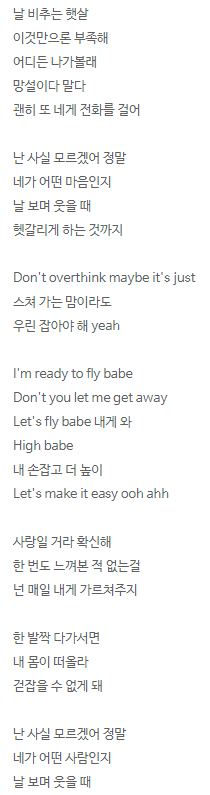

In [28]:
butterfly = ['날', '이것만으론', '어디든', '망설이다', '괜히', '난', '네가', '헷갈리게', 'dont', '스쳐']
for word in butterfly:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 날 이해할 수 있을까 <end> 
<start> <unk> <unk> <end> 
<start> 어디든 찾아갈게 <end> 
<start> 망설이다 놓쳐버릴 거야 <end> 
<start> 괜히 <unk> <end> 
<start> 난 <unk> <unk> <end> 
<start> 네가 나를 <unk> 때 <end> 
<start> 헷갈리게 하지 마 <end> 
<start> dont know whats going on <end> 
<start> 스쳐 지나갈 <end> 


all genre_임수-goood  
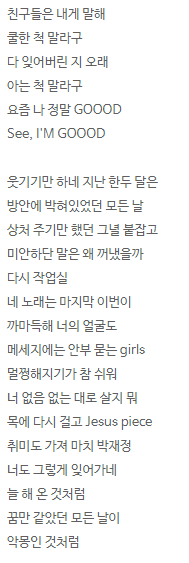

In [29]:
goood = ['친구들은', '쿨한', '다', '아는', '요즘', 'see', '웃기기만', '방안에', '상처', '미안하단']
for word in goood:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 친구들은 <unk> <end> 
<start> 쿨한 이별이 뭔지 몰라 <end> 
<start> 다 습관같지 <end> 
<start> 아는 이 길에서 <end> 
<start> 요즘 난 이상해 <end> 
<start> see you on facetime <end> 
<start> <unk> <unk> <end> 
<start> 방안에 벽을 <unk> 잠드네 <end> 
<start> 상처 같은 말을 내뱉고 <end> 
<start> 미안하단 말도 듣지 않겠지만 <end> 


: 